In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pylab as plt
import sklearn.linear_model as skl_lm  #library for machine (statistical) learning
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import sklearn
from sklearn import linear_model
import itertools
import scipy

2021-11-15 22:38:56.602889: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shailendra/rsoftware/root/lib/:/home/shailendra/rsoftware/root/lib:/home/shailendra/CLHEP/2.4.1.0-install/lib/:/home/shailendra/geant4/geant4.10.05.p01-build/BuildProducts/lib:/home/shailendra/geant4/geant4.10.05.p01-install/lib:/usr/lib/x86_64-linux-gnu/usr/lib:/usr/local/lib:/Applications/autotools/lib:/home/shailendra/CLHEP/2.4.1.0-install/lib:/home/shailendra/geant4/geant4.10.05.p01-install/lib:/home/shailendra/rsoftware/root/lib:/usr/local/lib:/usr/lib:/home/shailendra/anaroot/lib:/home/shailendra/geant4/geant4.10.05.p01-install/lib
2021-11-15 22:38:56.602921: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
thisdata = pd.read_csv('/home/shailendra/Documents/Stat_Learning/Assignment/Mandatory_Assignment/heart.csv', na_values='?').dropna() #read csv, DROPping Non Available data
thisdata.info()

#data = "/media/shailendra/New Volume1/Master_Data_Science_Oslo_met/ACIT4510/Assignment/Mandatory_Assignment/heart.csv"
#dataframe = pd.read_csv(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 35.5+ KB


In [4]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [5]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=100, facecolor='g', edgecolor='r')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=100)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=18)
    plt.show()

In [6]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 6: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:6]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [7]:
nRowsRead = 100000 # specify 'None' if want to read whole file
# heart.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/home/shailendra/Documents/Stat_Learning/Assignment/Mandatory_Assignment/heart.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'heart.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 303 rows and 14 columns


/tmp/ipykernel_22194/964395601.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nGraphRow, nGraphPerRow, i + 1)
/tmp/ipykernel_22194/964395601.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nGraphRow, nGraphPerRow, i + 1)


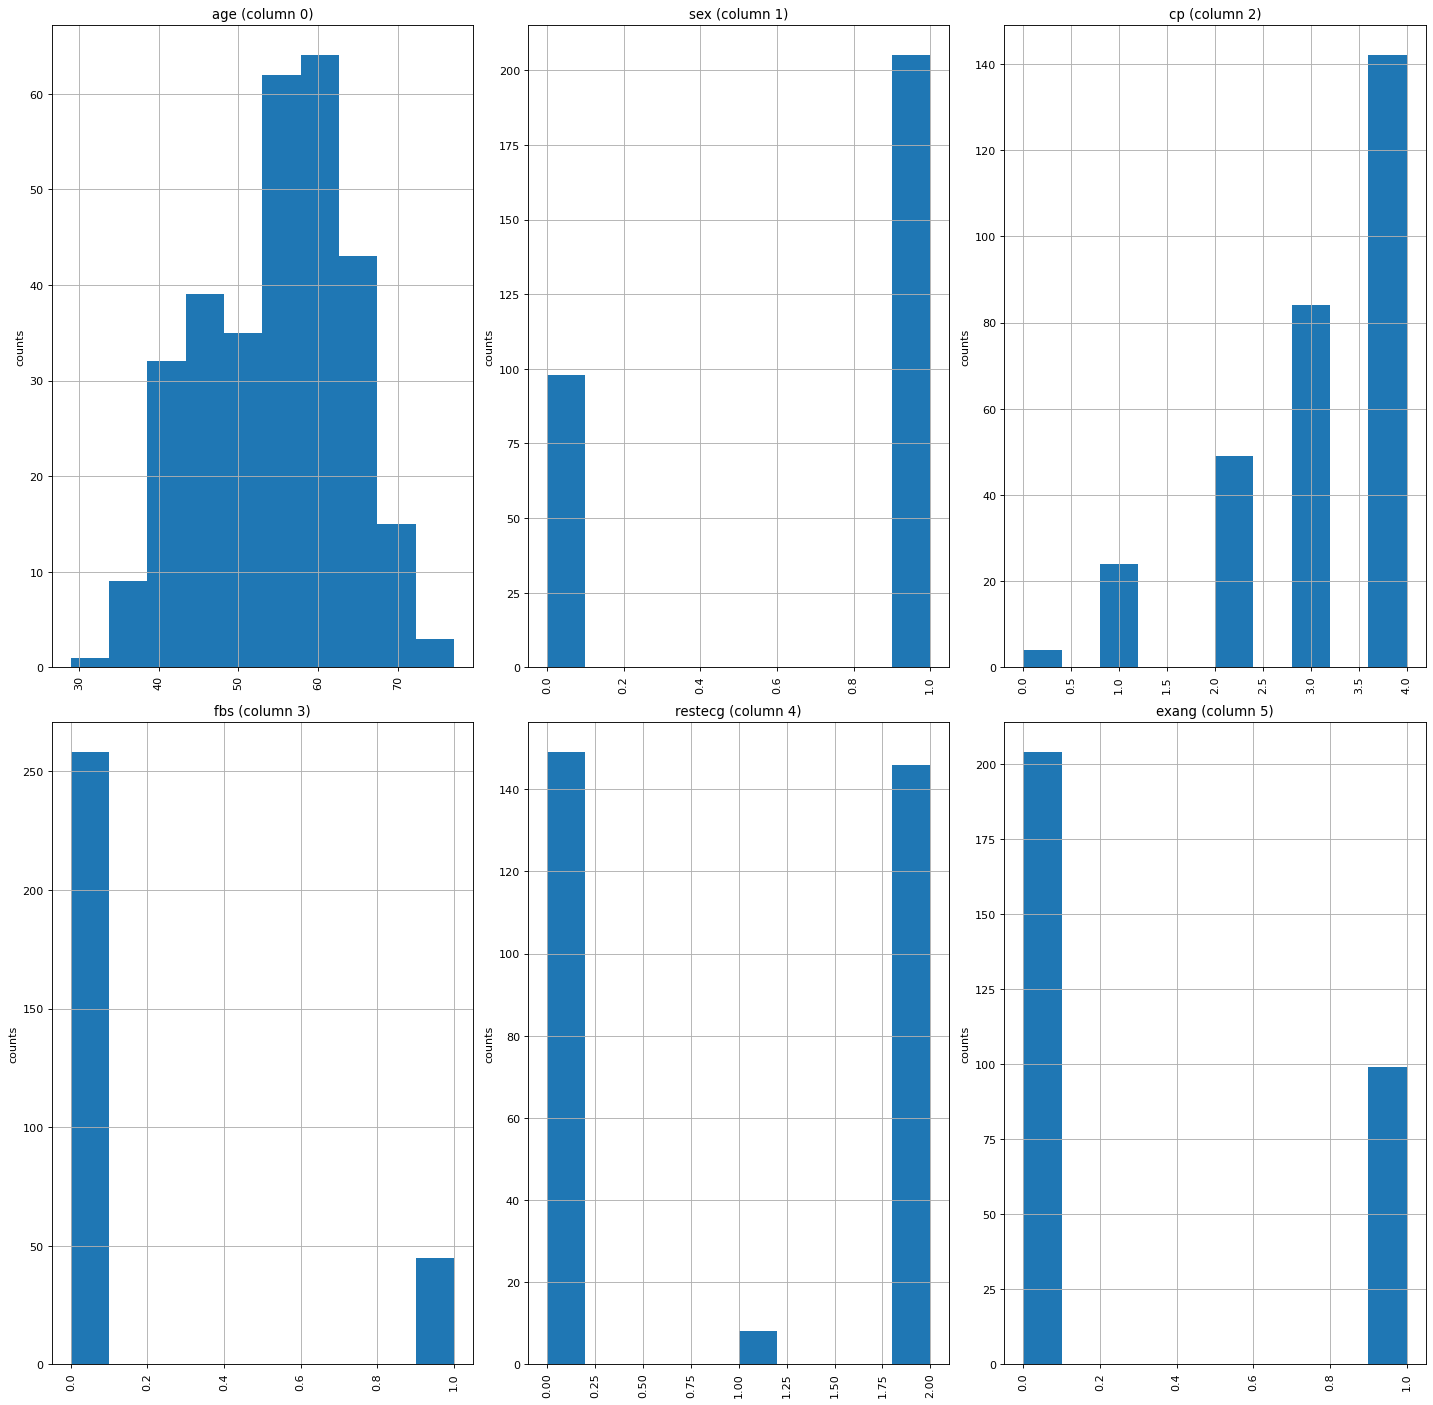

In [8]:
plotPerColumnDistribution(df1, 6, 3)

/tmp/ipykernel_22194/259811933.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  df = df.dropna('columns') # drop columns with NaN


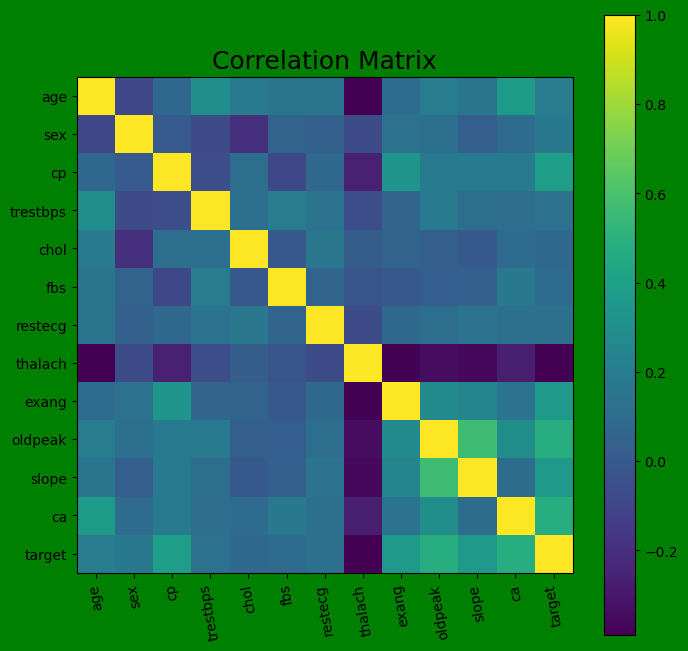

In [9]:
plotCorrelationMatrix(df1, 8)

In [11]:
#thisdata.drop('presence', axis=1).corrwith(dataframe.presence).plot(kind='bar', grid=True, figsize=(10, 5), title="Correlation with Target",color="indigo");

/tmp/ipykernel_22194/4272515009.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  df = df.dropna('columns')


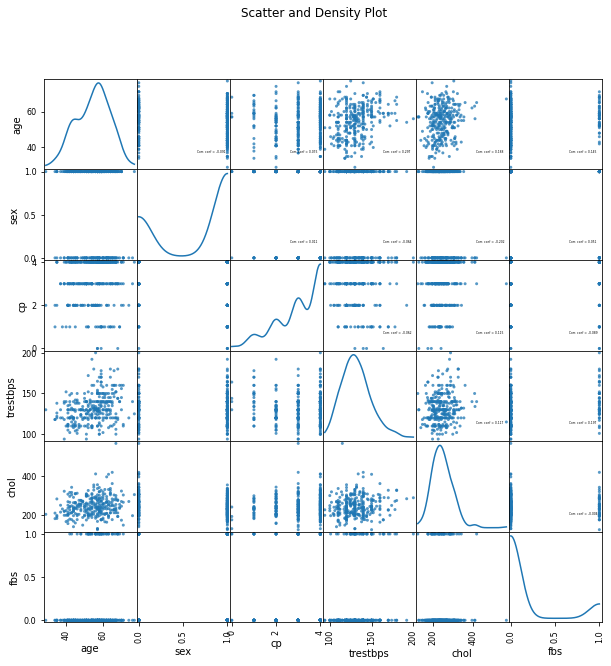

In [12]:
plotScatterMatrix(df1, 10, 3)

In [13]:
thisdata.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')


# Regression and classification

In [14]:
X = thisdata['trestbps']
Y = thisdata['chol']
#bin_vector = np.loadtxt('sacc_or_fixation.txt')

In [15]:
index_i = 30
index_f = 60

In [16]:
regx = np.array(X[index_i:index_f]).reshape((-1, 1))
regy = Y[index_i:index_f]

In [17]:
model = sklearn.linear_model.LinearRegression()

In [18]:
model.fit(regx,regy)
intercept = model.intercept_
coef = model.coef_
print(intercept)
print(coef)

127.15187094352464
[0.98948972]


In [19]:
model.score(regx, regy)

0.133713105233083

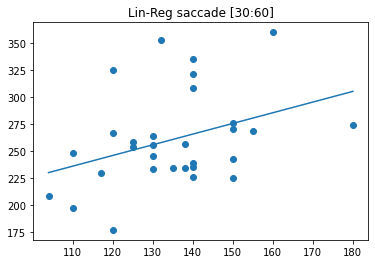

In [20]:
y0 = intercept + coef*min(regx)
y1 = intercept + coef*max(regx)

plt.plot([min(regx),max(regx)],[y0,y1])
plt.scatter(regx,regy)
plt.title("Lin-Reg saccade ["+str(index_i)+ ":" +str(index_f) + "]")
plt.savefig("Lin-Reg" + str(index_i),dpi=500)
np.savetxt("plot-x-sac-1",[min(regx),max(regx)])
np.savetxt("plot-y-sac-1",[y0,y1])
np.savetxt("scatter-x-sac-1",regx)
np.savetxt("scatter-y-sac-1",regy)
#plt.plot(regx,regy)

## Linear interpolation of Y in function of X during saccades (example 2)

In [21]:
index_i = 60
index_f = 90
regx = np.array(X[index_i:index_f]).reshape((-1, 1))
regy = Y[index_i:index_f]
model = sklearn.linear_model.LinearRegression()
model.fit(regx,regy)
intercept = model.intercept_
coef = model.coef_
print(intercept)
print(coef)

202.23472155479087
[0.23316057]


In [22]:
model.score(regx, regy)

0.01126417057954987

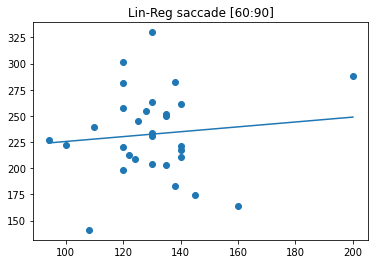

In [23]:
y0 = intercept + coef*min(regx)
y1 = intercept + coef*max(regx)

plt.plot([min(regx),max(regx)],[y0,y1])
plt.scatter(regx,regy)
#plt.plot(regx,regy)
plt.title("Lin-Reg saccade ["+str(index_i)+ ":" +str(index_f) + "]")
plt.savefig("Lin-Reg" + str(index_i),dpi=500)
np.savetxt("plot-x-sac-2",[min(regx),max(regx)])
np.savetxt("plot-y-sac-2",[y0,y1])
np.savetxt("scatter-x-sac-2",regx)
np.savetxt("scatter-y-sac-2",regy)

## Linear interpolation of Y in function of X during saccades (example 3)

In [24]:
index_i = 90
index_f = 120
regx = np.array(X[index_i:index_f]).reshape((-1, 1))
regy = Y[index_i:index_f]
model = sklearn.linear_model.LinearRegression()
model.fit(regx,regy)
intercept = model.intercept_
coef = model.coef_
print(intercept)
print(coef)

223.0824317560544
[0.40969468]


In [25]:
model.score(regx, regy)

0.014157597965960833

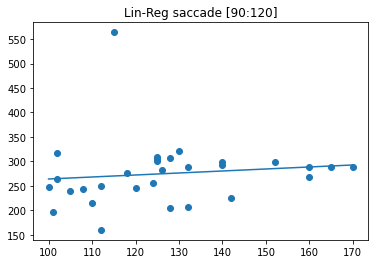

In [26]:
y0 = intercept + coef*min(regx)
y1 = intercept + coef*max(regx)

plt.plot([min(regx),max(regx)],[y0,y1])
plt.scatter(regx,regy)
plt.title("Lin-Reg saccade ["+str(index_i)+ ":" +str(index_f) + "]")
plt.savefig("Lin-Reg" + str(index_i),dpi=500)
np.savetxt("plot-x-sac-3",[min(regx),max(regx)])
np.savetxt("plot-y-sac-3",[y0,y1])
np.savetxt("scatter-x-sac-3",regx)
np.savetxt("scatter-y-sac-3",regy)
#plt.plot(regx,regy)

# Linear interpolation of Y in function of X during fixations (example 1)

In [27]:
index_i = 0
index_f = 30
regx = np.array(X[index_i:index_f]).reshape((-1, 1))
regy = Y[index_i:index_f]
model = sklearn.linear_model.LinearRegression()
model.fit(regx,regy)
intercept = model.intercept_
coef = model.coef_
print(intercept)
print(coef)

278.41169815305557
[-0.26255978]


## model.score(regx, regy)

In [28]:
model.score(regx, regy)

0.008215982835972802

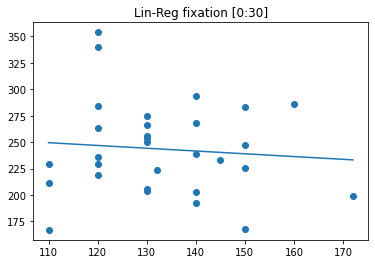

In [29]:
y0 = intercept + coef*min(regx)
y1 = intercept + coef*max(regx)

plt.plot([min(regx),max(regx)],[y0,y1])
plt.scatter(regx,regy)
plt.title("Lin-Reg fixation ["+str(index_i)+ ":" +str(index_f) + "]")
plt.savefig("Lin-Reg" + str(index_i),dpi=500)
np.savetxt("plot-x-fix-1",[min(regx),max(regx)])
np.savetxt("plot-y-fix-1",[y0,y1])
np.savetxt("scatter-x-fix-1",regx)
np.savetxt("scatter-y-fix-1",regy)
#plt.plot(regx,regy)

## Linear interpolation of Y in function of X during fixations (example 2)¶

In [30]:
index_i = 140
index_f = 165
regx = np.array(X[index_i:index_f]).reshape((-1, 1))
regy = Y[index_i:index_f]
model = sklearn.linear_model.LinearRegression()
model.fit(regx,regy)
intercept = model.intercept_
coef = model.coef_
print(intercept)
print(coef)

190.96789830158332
[0.38223229]


In [31]:
model.score(regx, regy)

0.03353776827322652

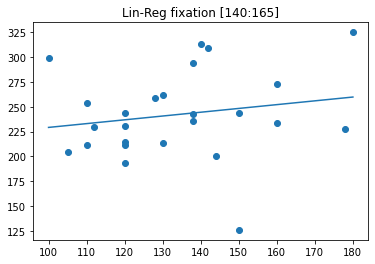

In [32]:
y0 = intercept + coef*min(regx)
y1 = intercept + coef*max(regx)

plt.plot([min(regx),max(regx)],[y0,y1])
plt.scatter(regx,regy)
plt.title("Lin-Reg fixation ["+str(index_i)+ ":" +str(index_f) + "]")
plt.savefig("Lin-Reg" + str(index_i),dpi=500)
np.savetxt("plot-x-fix-2",[min(regx),max(regx)])
np.savetxt("plot-y-fix-2",[y0,y1])
np.savetxt("scatter-x-fix-2",regx)
np.savetxt("scatter-y-fix2",regy)
#plt.plot(regx,regy)

## Linear interpolation of Y in function of X during fixations (example 3)

In [33]:
index_i = 170
index_f = 200
regx = np.array(X[index_i:index_f]).reshape((-1, 1))
regy = Y[index_i:index_f]
model = sklearn.linear_model.LinearRegression()
model.fit(regx,regy)
intercept = model.intercept_
coef = model.coef_
print(intercept)
print(coef)

154.3179321169315
[0.69815578]


In [34]:
model.score(regx, regy)

0.07809550860585801

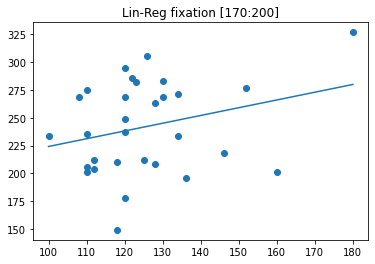

In [35]:
y0 = intercept + coef*min(regx)
y1 = intercept + coef*max(regx)

plt.plot([min(regx),max(regx)],[y0,y1])
plt.scatter(regx,regy)
plt.title("Lin-Reg fixation ["+str(index_i)+ ":" +str(index_f) + "]")
plt.savefig("Lin-Reg" + str(index_i),dpi=500)
np.savetxt("plot-x-fix-3",[min(regx),max(regx)])
np.savetxt("plot-y-fix-3",[y0,y1])
np.savetxt("scatter-x-fix-3",regx)
np.savetxt("scatter-y-fix-3",regy)
#plt.plot(regx,regy)

## Logistic regression

In [36]:
np.savetxt("xfig0",X[0:400])
np.savetxt("yfig0",Y[0:400])

In [37]:
fixations = [[0,30],[140,165],[170,200],[220,250],[260,330],[335,360],[370,400]]
saccades = [[30,60],[60,90],[90,120],[120,140],[165,170],[200,210],[210,220],[250,260],[330,335],[360,370]]
np.savetxt("fixations.txt",fixations)
np.savetxt("saccades.txt",saccades)

In [38]:
for i in range(len(fixations)):
    np.savetxt("X_fixation_"+str(i)+".txt",X[fixations[i][0]:fixations[i][1]+1])
    np.savetxt("Y_fixation_"+str(i)+".txt",Y[fixations[i][0]:fixations[i][1]+1])

for i in range(len(saccades)):
    np.savetxt("X_saccades_"+str(i)+".txt",X[saccades[i][0]:saccades[i][1]+1])
    np.savetxt("Y_saccades_"+str(i)+".txt",Y[saccades[i][0]:saccades[i][1]+1])

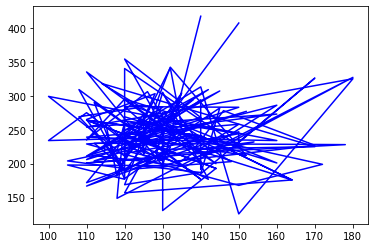

In [39]:
for i in range(len(fixations)):
    plt.plot(X[fixations[i][0]:fixations[i][1]+1],Y[fixations[i][0]:fixations[i][1]+1],c='b')
    np.savetxt("Xfix"+str(i),X[fixations[i][0]:fixations[i][1]+1])
    np.savetxt("Yfix"+str(i),Y[fixations[i][0]:fixations[i][1]+1])

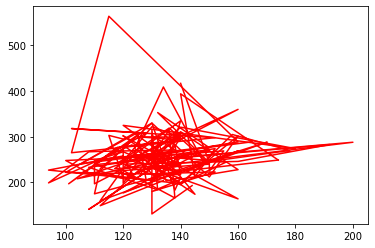

In [40]:
for i in range(len(saccades)):
    plt.plot(X[saccades[i][0]:saccades[i][1]+1],Y[saccades[i][0]:saccades[i][1]+1],c='r')
    np.savetxt("Xsac"+str(i),Y[saccades[i][0]:saccades[i][1]+1])
    np.savetxt("Ysac"+str(i),Y[saccades[i][0]:saccades[i][1]+1])

# Tree Based Method 

In [41]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz  #Library for graph drawing
#Some useful tools for constructing classification and regression trees (from library sklearn)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error

%matplotlib inline

In [42]:
df3 = pd.read_csv('heart.csv')
#print(thisdata.head())
#Take spurious first variable
#df3 = pd.read_csv('Carseats.csv').drop('Unnamed: 0', axis=1) #axis=1 means it drops columns (for rows use '0')
#df3 = pd.read_csv('Carseats.csv')
#print("\n")
#print("Cutting first column"+"\n")
#print(df3.head())
df3.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [43]:
df3['High'] = df3.age.map(lambda x: 1 if x>8 else 0)
df3.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,High
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0,1
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0,1
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0,1


## Little data cleaning to tidy things up

In [44]:
#df3.ShelveLoc = pd.factorize(df3.ShelveLoc)[0]
thalLocEnumerated, thalLocUniques = pd.factorize(df3.thal)
print(thalLocUniques)
print(thalLocEnumerated)

Index(['fixed', 'normal', 'reversible', '1', '2'], dtype='object')
[0 1 2 1 1 1 1 1 2 2 0 1 0 2 2 1 2 1 1 1 1 1 1 2 2 1 1 1 1 2 1 2 1 2 1 1 2
 0 2 1 2 1 2 2 0 1 1 2 1 1 2 1 1 1 2 1 1 1 1 1 1 2 2 1 1 2 2 0 1 1 2 1 2 1
 1 2 2 1 1 2 2 1 1 1 1 2 2 2 1 1 2 1 2 2 1 2 1 1 1 2 1 2 2 1 1 2 2 2 2 2 1
 1 1 1 2 1 2 1 2 2 1 1 0 2 2 0 1 1 2 2 1 2 1 1 2 0 2 2 1 2 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 1 1 1 2 1 2 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 1 1 1 1 1 1 1 1 2 1 2 1 0 2 2 1 1 1 1 1 1 2 1 1 1 1 1 0 0 2 1 2 0 2 1 1 2
 1 1 1 1 2 1 2 1 2 0 0 2 1 2 1 0 2 1 1 0 2 2 2 2 1 3 1 1 1 1 4 2 1 1 1 2 1
 2 1 1 1 2 1 1 2 2 2 2 1 1 2 1 2 1 2 2 1 2 2 1 2 2 1 1 1 1 1 1 2 2 2 2 2 2
 2 1 0 2 2 2 2]


# Decision Tree

In [45]:
X = df3.drop(['age', 'High'], axis = 1) #Predictors
#X.head()

In [46]:
y = df3.High #Response variable
#y.head()

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

In [49]:
# Choosing max depth 2
#regr_tree_boston = DecisionTreeRegressor(max_depth = 2)
# 
#regr_tree_boston.fit(X_train, y_train)

In [50]:
#classification_tree_heart = DecisionTreeClassifier(max_depth = 6)
#classification_tree_heart.fit(X_train, y_train) #Build a decision tree classifier from the training set (X,y).
#print(classification_tree_heart.get_depth()) #Return the depth of the decision tree.
#print(classification_tree_heart.get_n_leaves()) #Return the number of leaves of the decision tree.
#print(classification_tree_heart.score(X_train, y_train)) #Return the mean accuracy on the given test data and labels.

In [51]:
#export_graphviz(classification_tree_carseats, out_file = "heart_tree.dot", feature_names = X_train.columns)
#with open("heart_tree.dot") as f:
 #   dot_graph = f.read()
#graphviz.Source(dot_graph)

# Training Data Set

In [52]:
train_set = thisdata.sample(212, random_state = 1)  #random_state = set a seed

In [53]:
test_set = thisdata[~thisdata.isin(train_set)].dropna(how = 'all')

In [54]:
#Xtrain = train_set['horsepower']
#Ytrain = train_set['mpg']
#Xtest = test_set['horsepower']
#Ytest = test_set['mpg']
Xtrain = train_set['target'].values
Ytrain = train_set['age'].values
Xtest = test_set['target'].values
Ytest = test_set['age'].values
#print(Xtrain,'\n',Ytrain,'\n',Xtest,'\n',Ytest)

In [55]:
Xtrain = train_set['target'].values.reshape(-1,1) 
Ytrain = train_set['age'].values
Xtest = test_set['target'].values.reshape(-1,1)
Ytest = test_set['age'].values

In [56]:
lm = skl_lm.LinearRegression()
model = lm.fit(Xtrain, Ytrain)
#Ytrain = (model.coef_) * Xtrain + (model.intersept_)
print(model.coef_,model.intercept_)

[5.41871921] 52.35714285714286


In [57]:
predic = model.predict(Xtest) #Make prediction
#print(predic)
#Assess how good the model is
MSE = mean_squared_error(Ytest, predic)  #Error from "true" value (Ytest)
print(MSE)

72.56492640437286


In [58]:
# Quadratic polynomial (degree=2)
poly = PolynomialFeatures(degree=2)
Xtrain2 = poly.fit_transform(Xtrain) #IMPORTANT: Puts each X-value -> 1 / X / X^2
Xtest2 = poly.fit_transform(Xtest)
print(Xtrain[0:5],'\n',Xtrain2[0:5])
print(Xtest[0:5],'\n',Xtest2[0:5])

[[0]
 [0]
 [0]
 [0]
 [0]] 
 [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
[[1.]
 [0.]
 [0.]
 [1.]
 [0.]] 
 [[1. 1. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 1. 1.]
 [1. 0. 0.]]


In [59]:
# Make model
quadmodel = lm.fit(Xtrain2, Ytrain)
print(quadmodel.coef_,quadmodel.intercept_)
quadMSE = mean_squared_error(Ytest, quadmodel.predict(Xtest2))
print(quadMSE)

[ 0.00000000e+00  1.77434522e+15 -1.77434522e+15] 52.87042491079372
69.7817915037948


In [60]:
# Cubic polynomial
poly = PolynomialFeatures(degree=3)

# Puts each X-value -> 1 / X / X^2 / X^3
Xtrain3 = poly.fit_transform(Xtrain)
Xtest3 = poly.fit_transform(Xtest)

cubicmodel = lm.fit(Xtrain3, Ytrain)
print(cubicmodel.coef_,cubicmodel.intercept_)
cubicMSE = mean_squared_error(Ytest, model.predict(Xtest3))
print(cubicMSE)

[0.         1.80623974 1.80623974 1.80623974] 52.35714285714286
72.56492640437286


In [61]:
print("Polynomial order 4")
poly = PolynomialFeatures(degree=4)
Xtrain4 = poly.fit_transform(Xtrain)
Xtest4 = poly.fit_transform(Xtest)
model = lm.fit(Xtrain4, Ytrain)
MSE = mean_squared_error(Ytest, model.predict(Xtest4))
print("Coefficients for polynomial order 4")
print(model.coef_,model.intercept_)
print("and MSE:")
print(MSE)
print("Polynomial order 5")
poly = PolynomialFeatures(degree=5)
Xtrain5 = poly.fit_transform(Xtrain)
Xtest5 = poly.fit_transform(Xtest)
model = lm.fit(Xtrain5, Ytrain)
MSE = mean_squared_error(Ytest, model.predict(Xtest5))
print("Coefficients for polynomial order 5")
print(model.coef_,model.intercept_)
print("and MSE:")
print(MSE)
print("Polynomial order 6")
poly = PolynomialFeatures(degree=6)
Xtrain6 = poly.fit_transform(Xtrain)
Xtest6 = poly.fit_transform(Xtest)
model = lm.fit(Xtrain6, Ytrain)
MSE = mean_squared_error(Ytest, model.predict(Xtest6))
print("Coefficients for polynomial order 6")
print(model.coef_,model.intercept_)
print("and MSE:")
print(MSE)

Polynomial order 4
Coefficients for polynomial order 4
[ 0.00000000e+00  8.89114371e+14  5.36119381e+14  5.36119381e+14
 -1.96135313e+15] 52.822275757512124
and MSE:
69.9422116142803
Polynomial order 5
Coefficients for polynomial order 5
[ 0.00000000e+00  1.87470295e+15 -4.68675737e+14 -4.68675737e+14
 -4.68675737e+14 -4.68675737e+14] 53.27260455380039
and MSE:
68.5173471001489
Polynomial order 6
Coefficients for polynomial order 6
[ 0.00000000e+00  1.84995868e+15 -3.69991737e+14 -3.69991737e+14
 -3.69991737e+14 -3.69991737e+14 -3.69991737e+14] 52.81233125780686
and MSE:
69.99065015349072


In [62]:
# Make two other subsets (training and testing)
other_train_set = thisdata.sample(196, random_state = 2)
other_test_set = thisdata[~thisdata.isin(other_train_set)].dropna(how = 'all')  

Xtrain = other_train_set['target'].values.reshape(-1,1) 
Ytrain = other_train_set['age'].values
Xtest = other_test_set['target'].values.reshape(-1,1)
Ytest = other_test_set['age'].values

print("Linear fit")
model = lm.fit(Xtrain, Ytrain)
print(model.coef_,model.intercept_)
print(mean_squared_error(Ytest, model.predict(Xtest)))

print("Quadratic fit")
poly = PolynomialFeatures(degree=2)
Xtrain2 = poly.fit_transform(Xtrain)
Xtest2 = poly.fit_transform(Xtest)
model = lm.fit(Xtrain2, Ytrain)
print(model.coef_,model.intercept_)
print(mean_squared_error(Ytest, model.predict(Xtest2)))

print("Cubic fit")
poly = PolynomialFeatures(degree=3)
Xtrain3 = poly.fit_transform(Xtrain)
Xtest3 = poly.fit_transform(Xtest)
model = lm.fit(Xtrain3, Ytrain)
print(model.coef_,model.intercept_)
print(mean_squared_error(Ytest, model.predict(Xtest3)))

print("Polynomial order 4")
poly = PolynomialFeatures(degree=4)
Xtrain4 = poly.fit_transform(Xtrain)
Xtest4 = poly.fit_transform(Xtest)
model = lm.fit(Xtrain4, Ytrain)
MSE = mean_squared_error(Ytest, model.predict(Xtest4))
print("Coefficients for polynomial order 4")
print(model.coef_,model.intercept_)
print("and MSE:")
print(MSE)

print("Polynomial order 5")
poly = PolynomialFeatures(degree=5)
Xtrain5 = poly.fit_transform(Xtrain)
Xtest5 = poly.fit_transform(Xtest)
model = lm.fit(Xtrain5, Ytrain)
MSE = mean_squared_error(Ytest, model.predict(Xtest5))
print("Coefficients for polynomial order 5")
print(model.coef_,model.intercept_)
print("and MSE:")
print(MSE)

print("Polynomial order 6")
poly = PolynomialFeatures(degree=6)
Xtrain6 = poly.fit_transform(Xtrain)
Xtest6 = poly.fit_transform(Xtest)
model = lm.fit(Xtrain6, Ytrain)
MSE = mean_squared_error(Ytest, model.predict(Xtest6))
print("Coefficients for polynomial order 6")
print(model.coef_,model.intercept_)
print("and MSE:")
print(MSE)

Linear fit
[4.26785714] 53.57142857142857
76.88216133415983
Quadratic fit
[ 0.0000000e+00 -2.3509222e+15  2.3509222e+15] 53.0602455830605
77.92526256750848
Cubic fit
[0.         1.42261905 1.42261905 1.42261905] 53.57142857142857
76.88216133415983
Polynomial order 4
Coefficients for polynomial order 4
[0.         1.06696429 1.06696429 1.06696429 1.06696429] 53.57142857142857
and MSE:
76.88216133415983
Polynomial order 5
Coefficients for polynomial order 5
[0.         0.85357143 0.85357143 0.85357143 0.85357143 0.85357143] 53.57142857142857
and MSE:
76.88216133415983
Polynomial order 6
Coefficients for polynomial order 6
[0.         0.71130952 0.71130952 0.71130952 0.71130952 0.71130952
 0.71130952] 53.57142857142857
and MSE:
76.88216133415983


# Leave-One-Out Cross-Validation

In [63]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score  #needed for computing the errors

In [64]:
model = lm.fit(Xtrain, Ytrain)

Now, get the number of splitting iterations in the cross-validator (one-by-one leads to number of data points)

In [65]:
loo = LeaveOneOut()
X = thisdata['target'].values.reshape(-1,1)
y = thisdata['age'].values.reshape(-1,1)
nsplits = loo.get_n_splits(X)
print(nsplits)

303


In [66]:
crossvalidation = KFold(n_splits=303, random_state=None, shuffle=False)
scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=crossvalidation, n_jobs=1)
#print(scores)
print("Folds: " + str(len(scores)) + ", MSE: " + str(np.mean(np.abs(scores))) + ", STD: " + str(np.std(scores)))

Folds: 303, MSE: 78.79728943762962, STD: 98.00918152854511


In [67]:
for i in range(1,7):
    poly = PolynomialFeatures(degree=i)
    X_current = poly.fit_transform(X)
    model = lm.fit(X_current, y)
    scores = cross_val_score(model, X_current, y, scoring="neg_mean_squared_error", cv=crossvalidation,
 n_jobs=1)
    print("Degree-"+str(i)+" polynomial MSE: " + str(np.mean(np.abs(scores))) + ", STD: " + str(np.std(scores)))


Degree-1 polynomial MSE: 78.7972894376296, STD: 98.00918152854511
Degree-2 polynomial MSE: 78.8500779861855, STD: 98.01443130268301
Degree-3 polynomial MSE: 79.2275941693359, STD: 97.78315168085655
Degree-4 polynomial MSE: 79.25632327405556, STD: 97.56888176481029
Degree-5 polynomial MSE: 79.16701101864723, STD: 98.503022220069
Degree-6 polynomial MSE: 78.68693637361437, STD: 98.1788573677336


In [68]:
thiscrossvalidation = KFold(n_splits=10, shuffle=False)

In [69]:
for i in range(1,7):
    poly = PolynomialFeatures(degree=i)
    X_current = poly.fit_transform(X)
    model = lm.fit(X_current, y)
    scores = cross_val_score(model, X_current, y, scoring="neg_mean_squared_error", cv=thiscrossvalidation,
 n_jobs=1)
    print("Degree-"+str(i)+" polynomial MSE: " + str(np.mean(np.abs(scores))) + ", STD: " + str(np.std(scores)))

Degree-1 polynomial MSE: 78.54559695768863, STD: 10.782472155317986
Degree-2 polynomial MSE: 78.78397132028692, STD: 11.213278571652973
Degree-3 polynomial MSE: 78.89794409112395, STD: 11.093518414849601
Degree-4 polynomial MSE: 79.21649192417507, STD: 11.438718871190254
Degree-5 polynomial MSE: 78.77539600961971, STD: 11.166350860954262
Degree-6 polynomial MSE: 78.66936808739545, STD: 11.297788508106173


In [70]:
data = "heart.csv"
dataframe = pd.read_csv(data)


In [71]:
dataframe.shape

(303, 14)

In [72]:
print(data)

heart.csv


In [73]:
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [83]:
val_dataframe = dataframe.sample(frac=0.3, random_state=1)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 212 samples for training and 91 for validation


In [88]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [89]:
lm = skl_lm.LinearRegression()
model = lm.fit(Xtrain, Ytrain)
#Ytrain = (model.coef_) * Xtrain + (model.intersept_)
print(model.coef_,model.intercept_)

[4.26785714] 53.57142857142857


In [90]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=57>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=150>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=126>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'restecg': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=173>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=0.2>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'reversible'>}
Target: tf.Tensor(0, shape=(), dtype=int64)


In [91]:
train_ds = train_ds.batch(64)
val_ds = val_ds.batch(64)

In [92]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

# Model for analysis

In [123]:
sex = keras.Input(shape=(1,), name="sex", dtype="int64")
cp = keras.Input(shape=(1,), name="cp", dtype="int64")
fbs = keras.Input(shape=(1,), name="fbs", dtype="int64")
restecg = keras.Input(shape=(1,), name="restecg", dtype="int64")
exang = keras.Input(shape=(1,), name="exang", dtype="int64")
ca = keras.Input(shape=(1,), name="ca", dtype="int64")

# Categorical feature encoded as string
thal = keras.Input(shape=(1,), name="thal", dtype="string")

# Numerical features
age = keras.Input(shape=(1,), name="age")
trestbps = keras.Input(shape=(1,), name="trestbps")
chol = keras.Input(shape=(1,), name="chol")
thalach = keras.Input(shape=(1,), name="thalach")
oldpeak = keras.Input(shape=(1,), name="oldpeak")
slope = keras.Input(shape=(1,), name="slope")

all_inputs = [
    sex,
    cp,
    fbs,
    restecg,
    exang,
    ca,
    thal,
    age,
    trestbps,
    chol,
    thalach,
    oldpeak,
    slope,
]

# Integer categorical features
sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)
fbs_encoded = encode_categorical_feature(fbs, "fbs", train_ds, False)
restecg_encoded = encode_categorical_feature(restecg, "restecg", train_ds, False)
exang_encoded = encode_categorical_feature(exang, "exang", train_ds, False)
ca_encoded = encode_categorical_feature(ca, "ca", train_ds, False)

# String categorical features
thal_encoded = encode_categorical_feature(thal, "thal", train_ds, True)

# Numerical features
age_encoded = encode_numerical_feature(age, "age", train_ds)
trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

all_features = layers.concatenate(
    [
        sex_encoded,
        cp_encoded,
        fbs_encoded,
        restecg_encoded,
        exang_encoded,
        slope_encoded,
        ca_encoded,
        thal_encoded,
        age_encoded,
        trestbps_encoded,
        chol_encoded,
        thalach_encoded,
        oldpeak_encoded,
    ]
)
x = layers.Dense(64, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

# Plot of the model

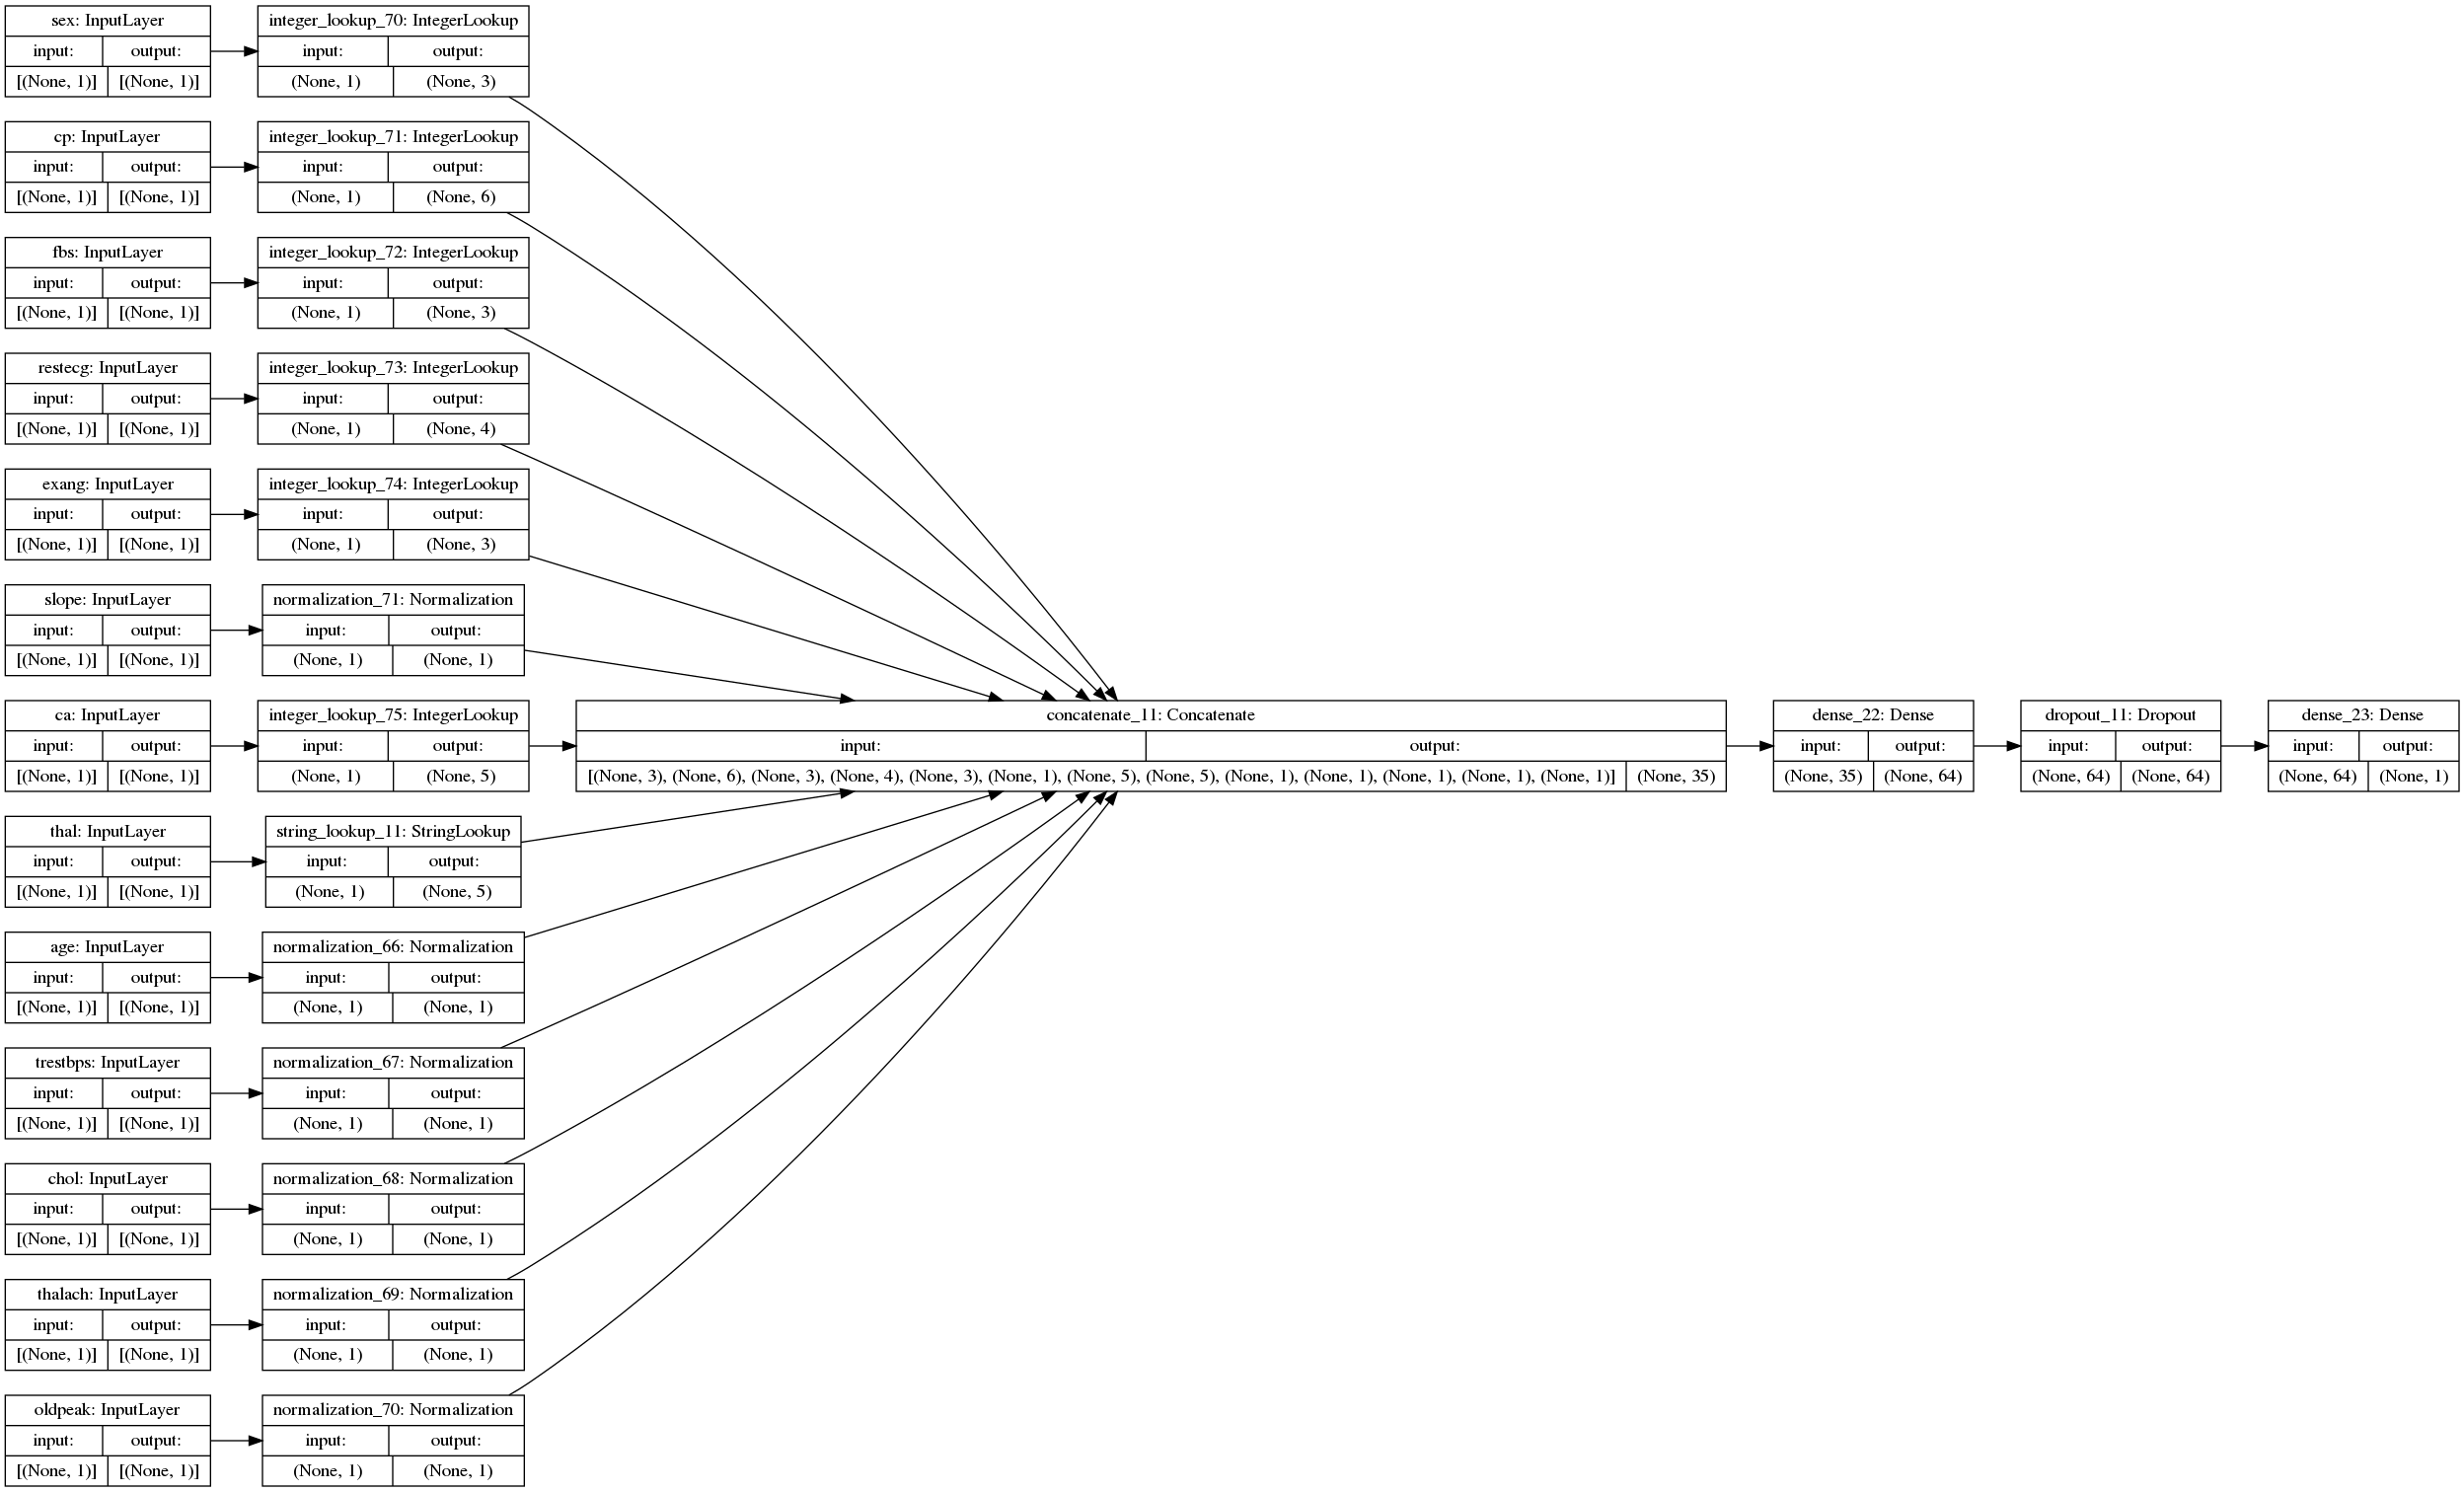

In [124]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [125]:
model.fit(train_ds, epochs=90, validation_data=val_ds)

Epoch 1/90
4/4 [==============================] - 1s 83ms/step - loss: 0.7309 - accuracy: 0.4953 - val_loss: 0.7156 - val_accuracy: 0.5604
Epoch 2/90
4/4 [==============================] - 0s 10ms/step - loss: 0.6815 - accuracy: 0.5849 - val_loss: 0.6769 - val_accuracy: 0.5824
Epoch 3/90
4/4 [==============================] - 0s 14ms/step - loss: 0.6172 - accuracy: 0.6840 - val_loss: 0.6438 - val_accuracy: 0.6484
Epoch 4/90
4/4 [==============================] - 0s 15ms/step - loss: 0.5923 - accuracy: 0.7075 - val_loss: 0.6153 - val_accuracy: 0.6484
Epoch 5/90
4/4 [==============================] - 0s 19ms/step - loss: 0.5768 - accuracy: 0.6887 - val_loss: 0.5911 - val_accuracy: 0.6703
Epoch 6/90
4/4 [==============================] - 0s 14ms/step - loss: 0.5829 - accuracy: 0.6934 - val_loss: 0.5700 - val_accuracy: 0.6813
Epoch 7/90
4/4 [==============================] - ETA: 0s - loss: 0.5417 - accuracy: 0.75 - 0s 15ms/step - loss: 0.5294 - accuracy: 0.7547 - val_loss: 0.5514 - val_ac

4/4 [==============================] - 0s 15ms/step - loss: 0.2919 - accuracy: 0.8774 - val_loss: 0.3455 - val_accuracy: 0.8352
Epoch 60/90
4/4 [==============================] - 0s 11ms/step - loss: 0.2758 - accuracy: 0.8774 - val_loss: 0.3450 - val_accuracy: 0.8462
Epoch 61/90
4/4 [==============================] - 0s 15ms/step - loss: 0.3019 - accuracy: 0.8774 - val_loss: 0.3445 - val_accuracy: 0.8462
Epoch 62/90
4/4 [==============================] - 0s 13ms/step - loss: 0.2878 - accuracy: 0.8726 - val_loss: 0.3437 - val_accuracy: 0.8462
Epoch 63/90
4/4 [==============================] - 0s 10ms/step - loss: 0.2827 - accuracy: 0.8726 - val_loss: 0.3432 - val_accuracy: 0.8462
Epoch 64/90
4/4 [==============================] - 0s 13ms/step - loss: 0.2884 - accuracy: 0.8679 - val_loss: 0.3429 - val_accuracy: 0.8462
Epoch 65/90
4/4 [==============================] - 0s 16ms/step - loss: 0.2782 - accuracy: 0.8632 - val_loss: 0.3425 - val_accuracy: 0.8462
Epoch 66/90
4/4 [===============

In [132]:
sample = {
    "age":60, 
    "sex": 1,   #1 for male and 0 female
    "cp": 4,  #Chest pain type 1, 2, 3, 4
    "trestbps": 120, # Fasting blood pressure(in mm Hg on admission)
    "chol": 308, # Serum Cholesteril in mg/dl
    "fbs": 1,  #fasting blood sugar in 120 mg/dl (1 = true; 0 = false)
    "restecg": 1, # Resting electrocardiogram results (0, 1, 2)
    "thalach": 150, #Maximum heart rate achieved
    "exang": 0,  #Exercise induced angina (1 = yes; 0 = no)
    "oldpeak": 2.3,
    "slope": 2,   #1 = upsloping 2 = flat 3 = downsloping
    "ca": 3,   #Number of major vessels (0-3)
    "thal": "fixed", # 0=fixed, 3 = normal; 6 = fixed defect; 7 = reversible defect
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "A 60 year old male patient with cp=4,bps=120,chol=308, fbs 1 and so on had a %.1f percent probability "
    "of having a heart disease, as evaluated by the model." % (100 * predictions[0][0],))

A 60 year old male patient with cp=4,bps=120,chol=308, fbs 1 and so on had a 78.6 percent probability of having a heart disease, as evaluated by the model.


# Plot for the results 

In [85]:
thisdata = pd.read_csv('probability.csv', na_values='?').dropna() #read csv, DROPping Non Available data
thisdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 0 to 25
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 26 non-null     int64  
 1   Probability Male    26 non-null     float64
 2   Probability Female  26 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 832.0 bytes


In [86]:
thisdata.columns

Index(['Age', 'Probability Male', 'Probability Female'], dtype='object')

In [87]:
thisdata.head()

,Age,Probability Male,Probability Female
0,40,47.2,44.4
1,41,47.2,44.7
2,42,47.7,44.9
3,43,48.0,45.1
4,44,48.2,45.3


In [88]:
X = thisdata['Age']
Y = thisdata['Probability Male']
Z = thisdata['Probability Female']
#bin_vector = np.loadtext('sacc_or_fixation.txt')

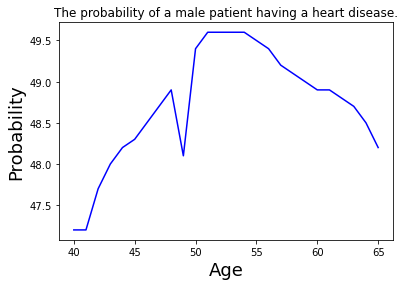

In [89]:
plt.plot(X[0:500],Y[0:500], c='b')
plt.title('The probability of a male patient having a heart disease.')
plt.xlabel('Age',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.savefig('/home/shailendra/Desktop/Fig/fig2.pdf')

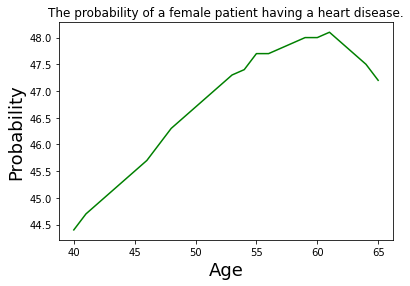

In [90]:
plt.plot(X[0:500],Z[0:500], c='g')
plt.title('The probability of a female patient having a heart disease.')
plt.xlabel('Age',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.savefig('/home/shailendra/Desktop/Fig/fig3.pdf')

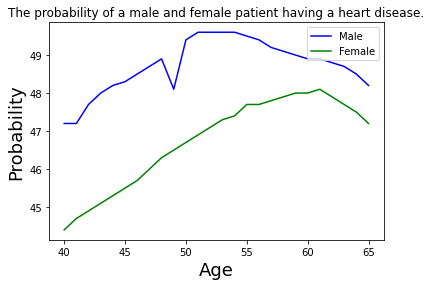

In [91]:
#plot1
plt.plot(X[0:500],Y[0:500], c='b', label='Male')
#plt.title('The probability of a male patient having a heart disease.')
#plt.xlabel('Age')
#plt.ylabel('Probability')

#plot2 
plt.plot(X[0:500],Z[0:500], c='g', label='Female')
plt.title('The probability of a male and female patient having a heart disease.')
plt.xlabel('Age',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.legend(loc="upper right")
plt.savefig('/home/shailendra/Desktop/Fig/fig1.pdf')



In [92]:
thisdata = pd.read_csv('probability1.csv', na_values='?').dropna() #read csv, DROPping Non Available data
thisdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 0 to 65
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   trestbps            66 non-null     int64  
 1   Probability Female  66 non-null     float64
 2   Probability Male    66 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 2.1 KB


In [93]:
thisdata.columns

Index(['trestbps', 'Probability Female', 'Probability Male'], dtype='object')

In [94]:
thisdata.head()

,trestbps,Probability Female,Probability Male
0,110,68.1,73.8
1,111,68.6,74.2
2,112,69.0,74.5
3,113,69.5,74.8
4,114,69.9,75.2


In [95]:
X = thisdata['trestbps']
Y = thisdata['Probability Male']
Z = thisdata['Probability Female']
#bin_vector = np.loadtext('sacc_or_fixation.txt')

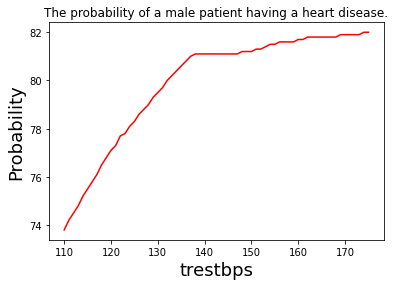

In [96]:
plt.plot(X[0:500],Y[0:500], c='red')
plt.title('The probability of a male patient having a heart disease.')
plt.xlabel('trestbps',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.savefig('/home/shailendra/Desktop/Fig/bp_fig2.pdf')

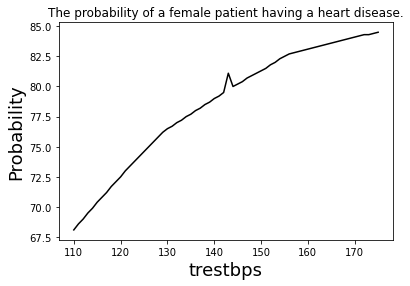

In [97]:
plt.plot(X[0:500],Z[0:500], c='black')
plt.title('The probability of a female patient having a heart disease.')
plt.xlabel('trestbps',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.savefig('/home/shailendra/Desktop/Fig/bp_fig3.pdf')

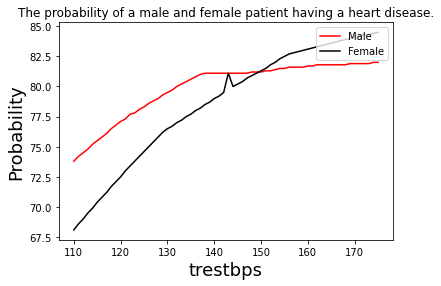

In [98]:
#plot1
plt.plot(X[0:500],Y[0:500], c='red', label='Male')
#plt.title('The probability of a male patient having a heart disease.')
#plt.xlabel('Age')
#plt.ylabel('Probability')

#plot2 
plt.plot(X[0:500],Z[0:500], c='black', label='Female')
plt.title('The probability of a male and female patient having a heart disease.')
plt.xlabel('trestbps',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.legend(loc="upper right")
plt.savefig('/home/shailendra/Desktop/Fig/bp_fig1.pdf')

In [99]:
data = pd.read_csv('probability2.csv', na_values='?').dropna() #read csv, DROPping Non Available data
thisdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 0 to 65
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   trestbps            66 non-null     int64  
 1   Probability Female  66 non-null     float64
 2   Probability Male    66 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 2.1 KB


In [100]:
data.columns

Index([' Thalach', 'Probability Male', 'Probability Female'], dtype='object')

In [101]:
data.head()

,Thalach,Probability Male,Probability Female
0,99,90.7,90.1
1,100,90.6,90.0
2,101,90.5,89.9
3,102,90.4,89.7
4,103,90.3,89.6


In [102]:
X = data[' Thalach']
Y = data['Probability Male']
Z = data['Probability Female']
#bin_vector = np.loadtext('sacc_or_fixation.txt')

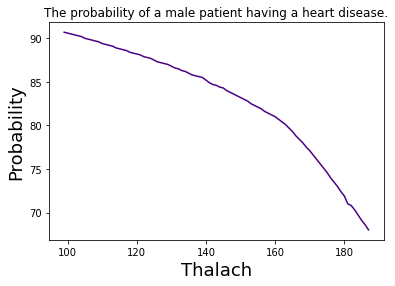

In [103]:
plt.plot(X[0:500],Y[0:500], c='indigo')
plt.title('The probability of a male patient having a heart disease.')
plt.xlabel('Thalach',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.savefig('/home/shailendra/Desktop/Fig/th_fig2.pdf')

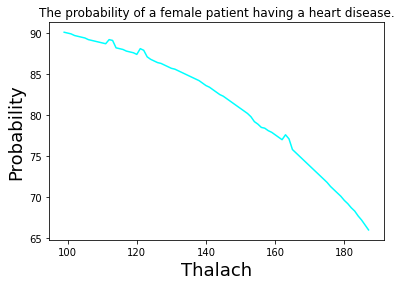

In [104]:
plt.plot(X[0:500],Z[0:500], c='cyan')
plt.title('The probability of a female patient having a heart disease.')
plt.xlabel('Thalach',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.savefig('/home/shailendra/Desktop/Fig/th_fig3.pdf')

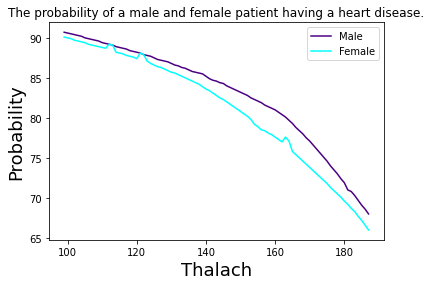

In [105]:
#plot1
plt.plot(X[0:500],Y[0:500], c='indigo', label='Male')
#plt.title('The probability of a male patient having a heart disease.')
#plt.xlabel('Age')
#plt.ylabel('Probability')

#plot2 
plt.plot(X[0:500],Z[0:500], c='cyan', label='Female')
plt.title('The probability of a male and female patient having a heart disease.')
plt.xlabel('Thalach',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.legend(loc="upper right")
plt.savefig('/home/shailendra/Desktop/Fig/th_fig1.pdf')

In [106]:
data = pd.read_csv('probability3.csv', na_values='?').dropna() #read csv, DROPping Non Available data
thisdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 0 to 65
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   trestbps            66 non-null     int64  
 1   Probability Female  66 non-null     float64
 2   Probability Male    66 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 2.1 KB


In [107]:
data.head()

,Chestpain,Probability Male,Probability Female
0,1,66.5,60.3
1,2,77.5,76.0
2,3,74.0,70.2
3,4,83.2,80.8


In [108]:
X = data['Chestpain']
Y = data['Probability Male']
Z = data['Probability Female']
#bin_vector = np.loadtext('sacc_or_fixation.txt')

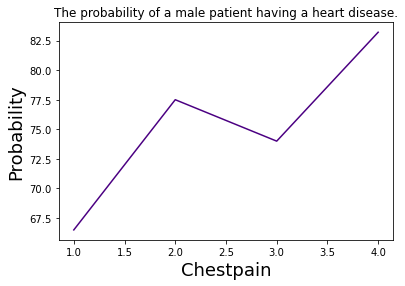

In [109]:
plt.plot(X[0:500],Y[0:500], c='indigo')
plt.title('The probability of a male patient having a heart disease.')
plt.xlabel('Chestpain',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.savefig('/home/shailendra/Desktop/Fig/cp_fig2.pdf')

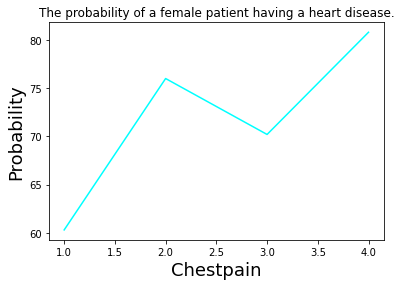

In [110]:
plt.plot(X[0:500],Z[0:500], c='cyan')
plt.title('The probability of a female patient having a heart disease.')
plt.xlabel('Chestpain',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.savefig('/home/shailendra/Desktop/Fig/cp_fig3.pdf')

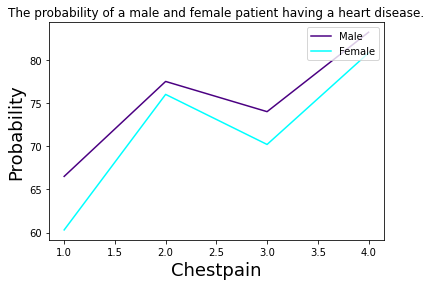

In [111]:
#plot1
plt.plot(X[0:500],Y[0:500], c='indigo', label='Male')
#plt.title('The probability of a male patient having a heart disease.')
#plt.xlabel('Age')
#plt.ylabel('Probability')

#plot2 
plt.plot(X[0:500],Z[0:500], c='cyan', label='Female')
plt.title('The probability of a male and female patient having a heart disease.')
plt.xlabel('Chestpain',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.legend(loc="upper right")
plt.savefig('/home/shailendra/Desktop/Fig/cp_fig1.pdf')

In [112]:
data = pd.read_csv('probability4Oldpeak.csv', na_values='?').dropna() #read csv, DROPping Non Available data
thisdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 0 to 65
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   trestbps            66 non-null     int64  
 1   Probability Female  66 non-null     float64
 2   Probability Male    66 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 2.1 KB


In [113]:
data.head()

,Oldpeak,Probability Male,Probability Female
0,0.0,58.2,51.2
1,0.1,59.8,52.9
2,0.2,61.3,54.6
3,0.3,62.7,56.3
4,0.4,63.9,58.0


In [114]:
X = data['Oldpeak']
Y = data['Probability Male']
Z = data['Probability Female']
#bin_vector = np.loadtext('sacc_or_fixation.txt')

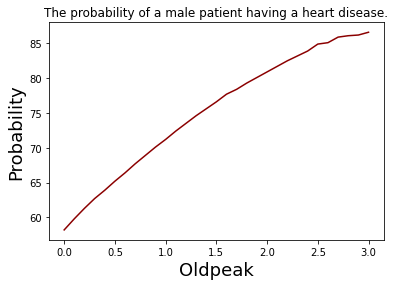

In [115]:
plt.plot(X[0:500],Y[0:500], c='darkred')
plt.title('The probability of a male patient having a heart disease.')
plt.xlabel('Oldpeak',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.savefig('/home/shailendra/Desktop/Fig/oldpeak_fig2.pdf')

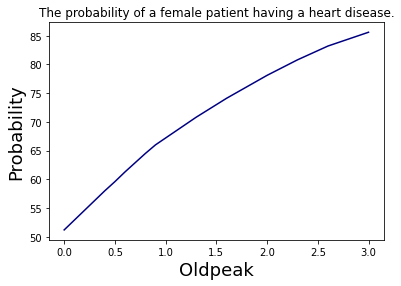

In [116]:
plt.plot(X[0:500],Z[0:500], c='navy')
plt.title('The probability of a female patient having a heart disease.')
plt.xlabel('Oldpeak',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.savefig('/home/shailendra/Desktop/Fig/oldpeak_fig3.pdf')

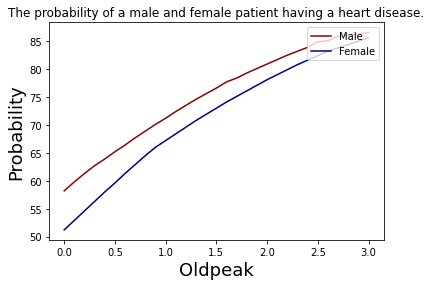

In [117]:
#plot1
plt.plot(X[0:500],Y[0:500], c='darkred', label='Male')
#plt.title('The probability of a male patient having a heart disease.')
#plt.xlabel('Age')
#plt.ylabel('Probability')

#plot2 
plt.plot(X[0:500],Z[0:500], c='navy', label='Female')
plt.title('The probability of a male and female patient having a heart disease.')
plt.xlabel('Oldpeak',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.legend(loc="upper right")
plt.savefig('/home/shailendra/Desktop/Fig/Old[peak_fig1.pdf')

In [118]:
data = pd.read_csv('probability4RestECG.csv', na_values='?').dropna() #read csv, DROPping Non Available data
thisdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 0 to 65
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   trestbps            66 non-null     int64  
 1   Probability Female  66 non-null     float64
 2   Probability Male    66 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 2.1 KB


In [119]:
data.head()

,RestECG,Probability Male,Probability Female
0,0,78.4,72.2
1,1,80.4,78.6
2,2,83.2,80.8


In [120]:
data.columns

Index(['RestECG', 'Probability Male ', 'Probability Female'], dtype='object')

In [121]:
X = data['RestECG']
Y = data['Probability Male ']
Z = data['Probability Female']
#bin_vector = np.loadtext('sacc_or_fixation.txt')

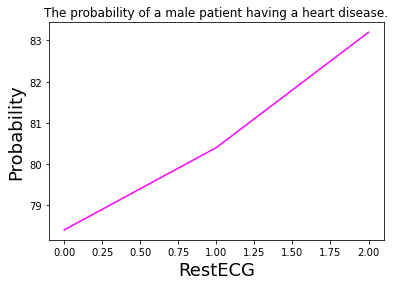

In [122]:
plt.plot(X[0:500],Y[0:500], c='magenta')
plt.title('The probability of a male patient having a heart disease.')
plt.xlabel('RestECG',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.savefig('/home/shailendra/Desktop/Fig/Restecg_fig2.pdf')

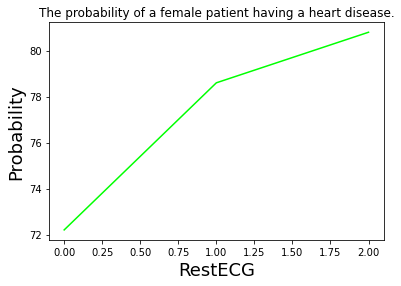

In [123]:
plt.plot(X[0:500],Z[0:500], c='lime')
plt.title('The probability of a female patient having a heart disease.')
plt.xlabel('RestECG',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.savefig('/home/shailendra/Desktop/Fig/Restecg_fig3.pdf')

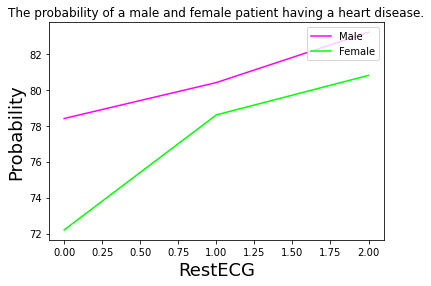

In [124]:
#plot1
plt.plot(X[0:500],Y[0:500], c='magenta', label='Male')
#plt.title('The probability of a male patient having a heart disease.')
#plt.xlabel('Age')
#plt.ylabel('Probability')

#plot2 
plt.plot(X[0:500],Z[0:500], c='lime', label='Female')
plt.title('The probability of a male and female patient having a heart disease.')
plt.xlabel('RestECG',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.legend(loc="upper right")
plt.savefig('/home/shailendra/Desktop/Fig/Restecg_fig1.pdf')